## FD 2d solver solution

In [112]:
from scipy.sparse import spdiags
from scipy.sparse.linalg import eigs
import numpy as np
import matplotlib.pyplot as plt

def operator_mat(prm,k0,h):
    Nx,Ny = prm.shape
    ke = k0**2*np.ravel(prm,order='F')
    d0 = (-4)*np.ones(ke.size)
    dadj = np.ones(Nx)
    dadj[-1] = 0.0
    dadj = np.tile(dadj,Ny)
    doff = np.ones(ke.size)
    
    L = (1/h**2)*spdiags([d0,dadj,np.flip(dadj),doff,doff],[0,-1,1,-Nx,Nx],ke.size,ke.size) + spdiags([ke],[0],ke.size,ke.size)
    return L



def guided_modes_2D(prm, k0, h, numb):
    """Computes the effective permittivity of a quasi-TE polarized guided 
    eigenmode. All dimensions are in µm.
    
    Parameters
    ----------
    prm  : 2d-array
        Dielectric permittivity in the xy-plane
    k0 : float
        Free space wavenumber
    h : float
        Spatial discretization
    numb : int
        Number of eigenmodes to be calculated
    
    Returns
    -------
    eff_eps : 1d-array
        Effective permittivity vector of calculated eigenmodes
    guided : 3d-array
        Field distributions of the guided eigenmodes
    """
    L = operator_mat(prm,k0,h)
    beta,modes = eigs(L,k=numb,which='LR')
    
    eps = beta/k0**2
    eps_r = np.real(eps)
    guided_eps = eps[np.where((eps_r<np.max(prm))&(eps_r>np.min(prm)))]
    guided_modes = modes[:,np.where((eps_r<np.max(prm))&(eps_r>np.min(prm)))[0]]
    sort_order = np.flip(np.argsort(np.real(guided_eps)))
    guided_eps = guided_eps[sort_order]
    
    guided_modes = guided_modes[:,sort_order]
    
    Nx,Ny = prm.shape
    guided = np.zeros((guided_eps.size,Nx,Ny),dtype=complex)
    for i in range(guided_eps.size):
        guided[i,:,:] = np.reshape(guided_modes[:,i],(Nx,Ny),order='F')
    
    eff_eps = guided_eps
    
    return eff_eps, guided

## Convergence test

In [113]:
def converg_test2d(grid_step_range,numb):
    grid_size = 150
    lam = 0.78
    k0 = 2*np.pi/lam
    e_substrate = 1.5**2
    delta_e = 1.5e-2
    w = 15.0
    
    eps = np.zeros((numb,grid_step_range.size),dtype = complex)
    for i in range(grid_step_range.size):
        h = grid_step_range[i]
        x = np.arange(-grid_size/2,grid_size/2+h,h)
        y = np.arange(-grid_size/2,grid_size/2+h,h)
        X,Y = np.meshgrid(x,y, indexing='ij')
        prm = e_substrate + delta_e*np.exp(-(X**2 + Y**2)/w**2)
    
        eff_eps, guided = guided_modes_2D(prm, k0, h, numb)
        eps[:,i] = eff_eps
        
    return eps
    

In [119]:
grid_step_range = np.linspace(4,2e-1,10)
numb = 5
test_eps = converg_test2d(grid_step_range,numb)

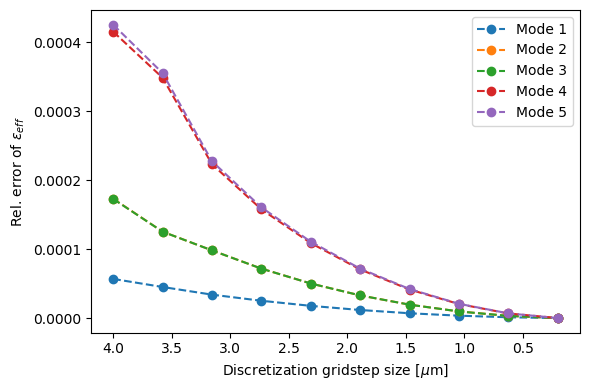

In [144]:
f1 = plt.figure(dpi=100)
for i in range(test_eps.shape[0]):
    relerr = np.abs((test_eps[i] - test_eps[i][-1])/test_eps[i][-1])
    plt.plot(grid_step_range,relerr,'o--',label='Mode {}'.format(i+1))

plt.legend()
plt.ylabel(r'Rel. error of $\epsilon_{eff}$')
plt.xlabel(r'Discretization gridstep size [$\mu$m]')
plt.gca().invert_xaxis()
f1.tight_layout()
plt.show()

## Plotting modes

In [155]:
# %%
grid_size     = 150
number_points = 751
h             = grid_size/(number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 1.5**2
delta_e       = 1.5e-2
w             = 15.0
x = np.linspace(-grid_size/2,grid_size/2,number_points)
y = np.linspace(-grid_size/2,grid_size/2,number_points)
X,Y = np.meshgrid(x,y, indexing='ij')
prm = e_substrate + delta_e*np.exp(-(X**2 + Y**2)/w**2)
    
eff_eps, guided = guided_modes_2D(prm, k0, h, 6)

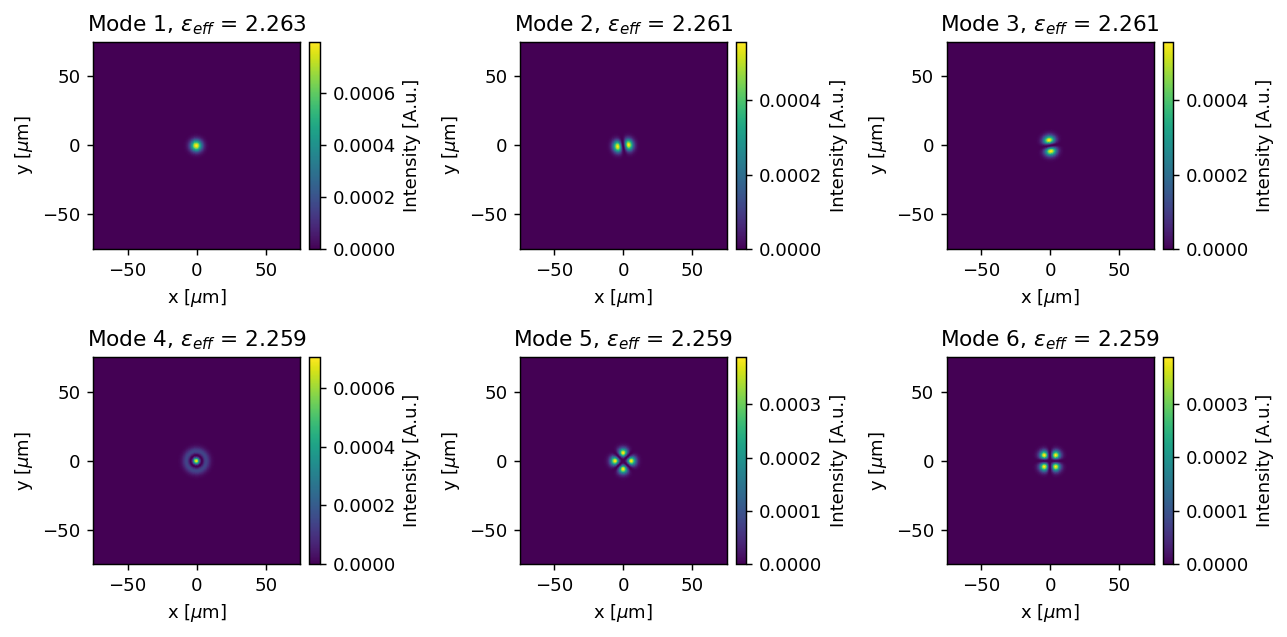

In [211]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tk
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    fmt = tk.ScalarFormatter(useOffset=True)
    fmt.set_scientific(1)
    return fig.colorbar(mappable, format=fmt,cax=cax)

f2, axs = plt.subplots(2,3,dpi=130,figsize=(10,5))
axs = axs.flatten()
for ax in axs:
    ax.axis('equal')

for i in range(eff_eps.size):
    cm = axs[i].pcolormesh(X,Y,np.abs(guided[i])**2)
    axs[i].set_ylabel(r'y [$\mu$m]')
    axs[i].set_xlabel(r'x [$\mu$m]')
    tstr = 'Mode {}, '.format(i+1) + r'$\epsilon_{eff}$ = ' + '{:.3f}'.format(np.real(eff_eps[i]))
    axs[i].set_title(tstr)
    cb = colorbar(cm)
    cb.set_label('Intensity [A.u.]')
    

f2.tight_layout()
plt.show()

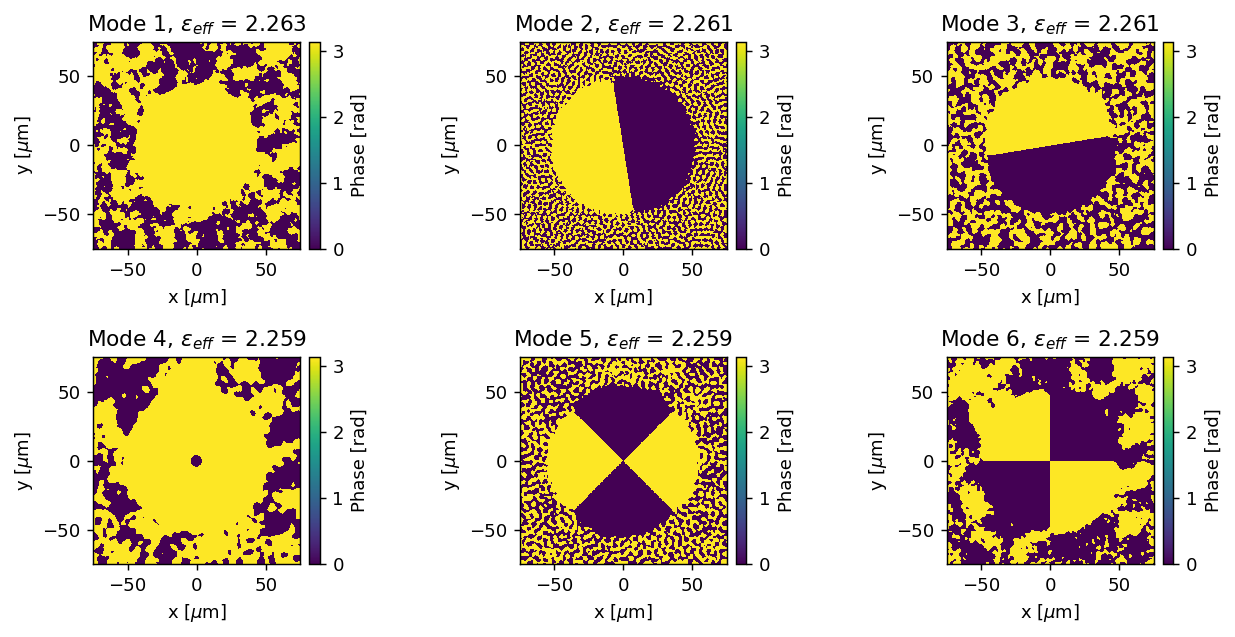

In [212]:
f3, axs = plt.subplots(2,3,dpi=130,figsize=(10,5))
axs = axs.flatten()
for ax in axs:
    ax.axis('equal')

for i in range(eff_eps.size):
    cm = axs[i].pcolormesh(X,Y,np.angle(guided[i]))
    axs[i].set_ylabel(r'y [$\mu$m]')
    axs[i].set_xlabel(r'x [$\mu$m]')
    tstr = 'Mode {}, '.format(i+1) + r'$\epsilon_{eff}$ = ' + '{:.3f}'.format(np.real(eff_eps[i]))
    axs[i].set_title(tstr)
    cb = colorbar(cm)
    cb.set_label('Phase [rad]')

f3.tight_layout()
plt.show()